In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import random_search_forecaster_multiseries
from skforecast.model_selection_multiseries import bayesian_search_forecaster_multiseries

# Se transforman los datos, se crean variables exogenas y se coloca la columna datetime como indice

In [3]:
df = pd.read_csv("df_time_serie_2022.csv")
df.FECHA = pd.to_datetime(df.FECHA)
df.set_index("FECHA", inplace=True)


# Se eliminan las columnas de más, de igual manera se eliminan los productos con menos de 50 ventas en 2023

In [4]:
df["Dia de la semana"] = df.index.dayofweek

In [5]:
exog = df[["Dia de la semana","Mes", "Dia", "Hora"]]
df.drop(columns=["Dia de la semana","Mes", "Dia", "Hora"], inplace=True)

In [6]:
#Agregar dia del mes


exog["Dia del mes"] = exog.index.day
#Convertir a dummies dia de la semana y mes
exog = pd.get_dummies(exog, columns=["Dia de la semana","Mes"])

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\766249261.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog["Dia del mes"] = exog.index.day


In [9]:
#Convert the days and hour to cos
exog["hour_cos"] = np.cos(2*np.pi*exog["Hora"]/24)
exog["hour_sin"] = np.sin(2*np.pi*exog["Hora"]/24)
exog["day_cos"] = np.cos(2*np.pi*exog["Dia del mes"]/31)
exog["day_sin"] = np.sin(2*np.pi*exog["Dia del mes"]/31)
exog["Dia del año cos"] = np.cos(2*np.pi*exog["Dia"]/365)
exog["Dia del año sin"] = np.sin(2*np.pi*exog["Dia"]/365)
#drop
exog.drop(columns=["Hora","Dia del mes","Dia"], inplace=True)
exog

,Dia de la semana_0,Dia de la semana_1,Dia de la semana_2,Dia de la semana_3,Dia de la semana_4,Dia de la semana_5,Dia de la semana_6,Mes_1.0,Mes_2.0,Mes_3.0,...,Mes_9.0,Mes_10.0,Mes_11.0,Mes_12.0,hour_cos,hour_sin,day_cos,day_sin,Dia del año cos,Dia del año sin
FECHA,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,1.000000,0.000000,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 01:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,0.965926,0.258819,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 02:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,0.866025,0.500000,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 03:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,0.707107,0.707107,0.979530,2.012985e-01,0.999852,0.017213
2022-01-01 04:00:00,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,0.500000,0.866025,0.979530,2.012985e-01,0.999852,0.017213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31 21:00:00,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,0.707107,-0.707107,1.000000,-2.449294e-16,-0.865307,-0.501242
2024-07-31 22:00:00,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,0.866025,-0.500000,1.000000,-2.449294e-16,-0.865307,-0.501242
2024-07-31 23:00:00,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,0.965926,-0.258819,1.000000,-2.449294e-16,-0.865307,-0.501242


In [10]:
df = df.asfreq("h")

Crear Exog asfreq h sin valores nulos, cambiar tipo de valor de bool a int

In [11]:
exog = exog.asfreq("h")
#Convert bool to int
exog = exog.astype(int)

In [12]:
# Seleccionar las columnas que contengan la palabra "SURESTE" y no "SURESTE 2" o "SURESTE 3"
x = df.filter(regex=("SURESTE(?! 2| 3)")).columns

# Se divide el test en validacion, test y entrenamiento

In [13]:
# Split data into train-validation-test
# ======================================================================================
end_train = '2024-02-29 23:00:00'
end_val = '2024-07-30 23:00:00'

data_train = df.loc[:end_train, :].copy()
data_val   = df.loc[end_train:end_val, :].copy()
data_test  = df.loc[end_val:, :].copy()
exog_train = exog.loc[:end_train, :].copy()
exog_val   = exog.loc[end_train:end_val, :].copy()
exog_test  = exog.loc[end_val:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2024-02-29 23:00:00  (n=18960)
Validation dates : 2024-02-29 23:00:00 --- 2024-07-30 23:00:00  (n=3649)
Test dates       : 2024-07-30 23:00:00 --- 2024-07-31 23:00:00  (n=25)


Medidas a cambiar a futuro:
Tiempo a predecir: 6 horas adelante, 12 horas adelante y un día.

ForecasterAutoregMultiVariate, con todo el dataframe, con una estación.

Algunas de los trends que hay

## Se buscan los mejores hiperparametros para el modelo por grid-search y se guardan en un dataframe

Intento con datos de una estación, solo 6 horas

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
modelos_pruebas = {}
# ==============================================================================
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [6, 12, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 25),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt']),
        'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 70, 160),
        'max_depth': trial.suggest_int('max_depth', -1, 15),  # -1 for no limit
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0)

    }

    return search_space

def r_squared(y_true, y_pred):
    return 1 - r2_score(y_true, y_pred)

for level in df.filter(regex=("PM2.5")).columns:
    forecaster = ForecasterAutoregMultiVariate(
                    regressor = LGBMRegressor(random_state=123, verbose=-1),
                    level     = level, #cambiar nivel a predecir 
                    lags      = 24,
                    steps     = 6
                )
    
    results, best_trial = bayesian_search_forecaster_multiseries(
                            forecaster            = forecaster,
                            series                = df,
                            exog                  = exog, 
                            search_space          = search_space,
                            steps                 = 6,
                            metric                = [r_squared, 'mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error' ],
                            # aggregate_metric      = 'weighted_average',
                            refit                 = False, #Se reentrena cada 3 folds
                            initial_train_size    = len(data_train),
                            fixed_train_size      = False,
                            n_trials              = 5,
                            random_state          = 123,
                            return_best           = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True,
                            engine                = 'optuna',
                            kwargs_create_study   = {},
                            kwargs_study_optimize = {}
                            # output_file="results_" + level + ".txt"
                        )
    modelos_pruebas[level] = results
    results.head(4)

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

  0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
C:\Users\jesus\AppData\Local\Temp\ipykernel_34428\3972987981.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_logunifo

## CODIGO MUESTRA DE MODELOS DISTINTOS

In [ ]:
# Hyperparameter search and backtesting of each item's model
# ======================================================================================
items = []
mae_values  = []
dictes = {}

lags_grid = [7, 14, 21]
param_grid = {
    'max_iter': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

for i, item in enumerate(data.columns):

    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123),
                     lags          = 14,
                     transformer_y = StandardScaler()
                 )

    results_grid = grid_search_forecaster(
                       forecaster         = forecaster,
                       y                  = data.loc[:end_val, item],
                       lags_grid          = lags_grid,
                       param_grid         = param_grid,
                       steps              = 7,
                       exog=exog.loc[:end_val, :],
                       metric             = "mean_absolute_error",
                       initial_train_size = len(data_train),
                       refit              = False,
                       fixed_train_size   = False,
                       return_best        = True,
                       verbose            = False,
                       show_progress      = False 
                  )

    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        exog=exog,
                        initial_train_size = len(data_train) + len(data_val),
                        steps              = 7,
                        metric             = "mean_absolute_error",
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    dictes[item] = results_grid
    

uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

# Forecaster multi-variate to model each region together

In [56]:
sureste = df.filter(regex=("SURESTE")).columns

In [ ]:
sureste

In [ ]:
# Bayesian search hyperparameters and lags with Optuna
# ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 level     = 'SURESTE PM2.5 (UG/M3)',
                 lags      = 24,
                 steps     = 6
             )

# Search space
def search_space(trial):
    search_space  = {
        'lags'            : trial.suggest_categorical('lags', [7, 14]),
        'n_estimators'    : trial.suggest_int('n_estimators', 10, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1., 10),
        'max_features'    : trial.suggest_categorical('max_features', ['log2', 'sqrt'])
    }

    return search_space

results, best_trial = bayesian_search_forecaster_multiseries(
                          forecaster            = forecaster,
                          series                = df[sureste],
                          exog                  = exog, 
                          search_space          = search_space,
                          steps                 = 6,
                          metric                = ['mean_absolute_error', 'mean_squared_error', 'mean_absolute_percentage_error' ],
                          aggregate_metric      = 'weighted_average',
                          refit                 = 3, #Se reentrena cada 3 folds
                          initial_train_size    = len(data_train),
                          fixed_train_size      = False,
                          n_trials              = 5,
                          random_state          = 123,
                          return_best           = False,
                          n_jobs                = 'auto',
                          verbose               = True,
                          show_progress         = True,
                          engine                = 'optuna',
                          kwargs_create_study   = {},
                          kwargs_study_optimize = {}
                      )
results.head(4)

Obtener una tabla con R^2,  MSE, RSME

# Se hará un modelo por region

Se puede guardar cada modelo en un csv, que puede ser releido para usarse en el futuro, pero es recomendable reentrenar cada mes

Se crea un dataframe con cada uno de los parametros necesarios

Se entrena cada modelo y se predice para una semana y para un mes, se guarda en un dataframe cada predicción

In [68]:
#Get each first part of the column name
regions = df.columns.str.split(" ").str[0].unique()

In [ ]:
for region in regions:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
    forecaster = ForecasterAutoregMultiVariate(
                    regressor          = LGBMRegressor(random_state=123, verbose=-1),
                    level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                    lags               = 21,
                    steps              = 6,
                    transformer_series = StandardScaler(),
                    transformer_exog   = None,
                    weight_func        = None,
                    n_jobs             = 'auto'
                    min_samples_leaf   = 9,
                    n_estimators       = 10,
                    max_features       = 'log2'
                    
                )

    forecaster.fit(series=data_train.filter(regex=(region)), exog=exog_train)
    predictions = forecaster.predict(steps=6, last_window=data_val.filter(regex=(region)), exog=exog_val)
    

In [50]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                regressor          = LGBMRegressor(random_state=123, verbose=-1),
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 14,
                steps              = 12,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto'
                    
            )

forecaster.fit(series=data_train.filter(regex=("SURESTE")), exog=exog_train)


In [51]:
predictions = forecaster.predict(steps=12,exog=exog_val.loc["2024-03-01 00:00:00":])


Puede predecir 6 horas

2024-07-31 05:00:00

In [30]:
predictions

,SURESTE PM2.5 (UG/M3)
2024-03-01 00:00:00,17.033942
2024-03-01 01:00:00,15.941695
2024-03-01 02:00:00,15.698637
2024-03-01 03:00:00,17.126116
2024-03-01 04:00:00,15.643313
2024-03-01 05:00:00,16.590759


In [52]:
# Get the models stats
data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12)

,SURESTE PM2.5 (UG/M3)
FECHA,
2024-03-01 00:00:00,18.287877
2024-03-01 01:00:00,15.000000
2024-03-01 02:00:00,14.000000
2024-03-01 03:00:00,15.000000
2024-03-01 04:00:00,15.000000
2024-03-01 05:00:00,16.000000
2024-03-01 06:00:00,19.000000
2024-03-01 07:00:00,22.000000
2024-03-01 08:00:00,24.000000


In [53]:
# Get the R^2, RMSE, MAE and MAPE
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions, squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")


R^2: 0.4099763148337019
RMSE: 6.956588344307862
MAE: 3.906903141382457
MAPE: 0.12314507501120897


c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\personal\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


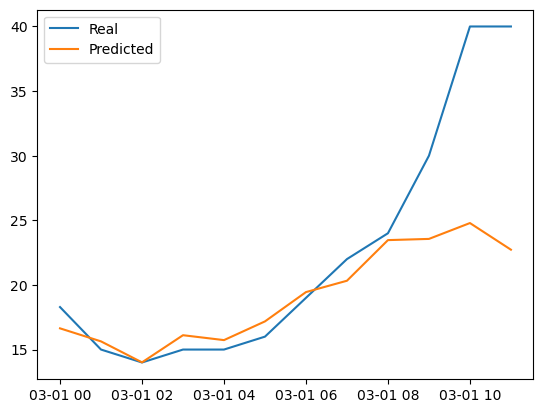

In [54]:
# Plot the predicted, vs real
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

# Modelo con datos de una sola estacion

In [55]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                regressor          = LGBMRegressor(random_state=123, verbose=-1),
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 14,
                steps              = 12,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto',
                    
            )

forecaster.fit(data_train.filter(regex=("SURESTE(?! 2| 3)")), exog=exog_train)

In [56]:
predictions = forecaster.predict(steps=12, exog=exog_val.loc["2024-03-01 00:00:00":])
predictions


,SURESTE PM2.5 (UG/M3)
2024-03-01 00:00:00,16.736356
2024-03-01 01:00:00,16.338487
2024-03-01 02:00:00,16.329758
2024-03-01 03:00:00,16.928768
2024-03-01 04:00:00,16.184626
2024-03-01 05:00:00,18.644283
2024-03-01 06:00:00,16.842215
2024-03-01 07:00:00,20.887210
2024-03-01 08:00:00,20.088968
2024-03-01 09:00:00,21.145663


In [57]:
# Get the R^2, RMSE, MAE and MAPE
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions, squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), predictions)

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R^2: 0.32185812339974573
RMSE: 7.4579911515389705
MAE: 5.004610060834536
MAPE: 0.1801342778142503


c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\personal\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


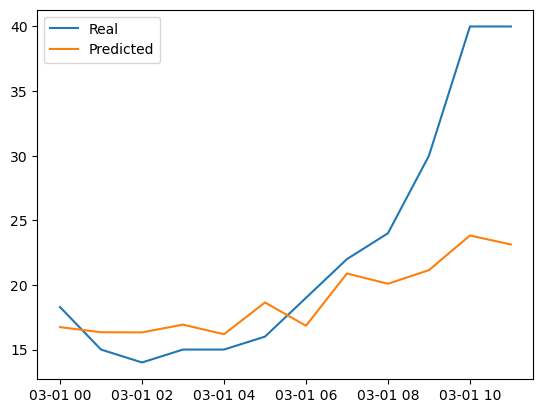

In [58]:
# Plot the predicted, vs real
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(12), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

# Modelo con todos los datos

In [60]:
    # Create and fit forecaster MultiVariate
    # ==============================================================================
forecaster = ForecasterAutoregMultiVariate(
                regressor          = LGBMRegressor(random_state=123, verbose=-1),
                level              = 'SURESTE PM2.5 (UG/M3)', #Hay que hacer que cambie de SURESTE a SURESTE 2, 3 y cada region tiene sus propios numeros
                lags               = 32,
                steps              = 18,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                n_jobs             = 'auto',
                    
            )

forecaster.fit(data_train, exog=exog_train)

In [61]:
predictions = forecaster.predict(steps=18, exog=exog_val.loc["2024-03-01 00:00:00":])

In [62]:
# Get the R^2, RMSE, MAE and MAPE
r2 = r2_score(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(18), predictions)
rmse = mean_squared_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(18), predictions, squared=False)
mae = mean_absolute_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(18), predictions)
mape = mean_absolute_percentage_error(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(18), predictions)

print(f"R^2: {r2}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

R^2: 0.6172253891793503
RMSE: 5.603161543417696
MAE: 4.218212972460105
MAPE: 0.17048186712217514


c:\Users\progra.DESKTOP-GV4Q93K\miniconda3\envs\personal\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


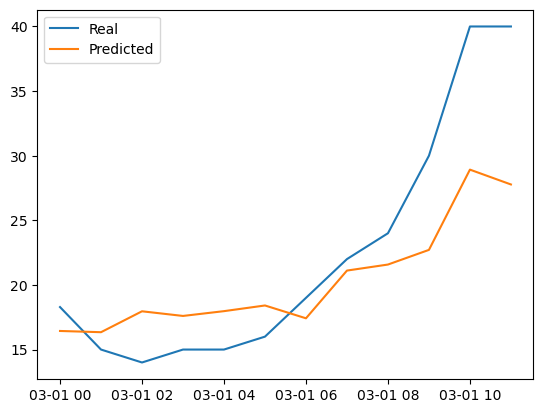

In [63]:
# Plot the predicted, vs real
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-03-01"].head(18), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

In [ ]:
plt.plot(data_val.filter(regex=("SURESTE PM2.5")).loc["2024-02-01":].head(36), label="Real")
plt.plot(predictions, label="Predicted")
plt.legend()

In [32]:
for i in models.index:
    forecaster = ForecasterAutoreg(
                     regressor     = HistGradientBoostingRegressor(random_state=123, max_depth=models.loc[i,"max_depth"], max_iter=models.loc[i,"max_iter"], learning_rate=models.loc[i,"learning_rate"]),
                     lags          = [models.loc[i,"lags"].max()],
                     transformer_y = StandardScaler()
                 )
    forecaster.fit(y=data.loc[:"2023-11-30",i], exog=exog.loc[:"2023-11-30", :])
    month_pred[i] = forecaster.predict(steps=31, exog=exog.loc["2023-12-01":])
    week_pred[i] = forecaster.predict(steps=8, exog=exog.loc["2023-12-01":])

Se ayuda un poco al modelo dado que los valores negativos no existen en los productos

Se consiguen las estadisticas que tiene el modelo para predecir durante un mes y durante una semana

In [ ]:
stats_mes = pd.DataFrame()
for i in month_pred.columns:
    y_pred = month_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-31",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real
    error_semanal = error/4 * 100
    stats_mes = pd.concat([stats_mes, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error*100, "error por semana": error_semanal}, index=[0])], axis=0)
stats_mes

In [ ]:
stats_semana = pd.DataFrame()
for i in month_pred.columns:
    y_pred = week_pred[i]
    y_test = data.loc["2023-12-01":"2023-12-8",i]
    mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
    mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
    r2 = r2_score(y_true=y_test, y_pred=y_pred)
    mape2 = abs((y_pred - y_test)/y_test).replace([np.inf, -np.inf], np.log(0.9999999999999999999999999)).dropna().sum()/30
    mape3 = (np.abs((y_test - y_pred)/np.where(y_test==0, 1, y_test))).mean()
    smape = 1/len(y_test) * np.sum(2*np.abs(y_pred - y_test)/(np.abs(y_pred) + np.abs(y_test))*100)
    valor_real = y_test.sum()
    valor_pred = y_pred.sum()
    error = (valor_real - valor_pred)/valor_real *100
    stats_semana = pd.concat([stats_semana, pd.DataFrame({"Producto":i, "MAE":mae, "MSE":mse, "R2":r2, "SMAPE": smape,"MAPE lib":mape,"MAPE2":mape2,"MAPE3":mape3, "valor real": 
        valor_real, "valor predecido": valor_pred, "error":error}, index=[0])], axis=0)
stats_semana

In [ ]:
#Save figure#
for i in month_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    month_pred[i].plot(ax=ax,color='red', linestyle='--', label='Predicciones')
    data.loc["2023-12-01":"2023-12-31",i].plot(ax=ax,color='blue', linestyle='-', label='Valores reales')
    ax.set_title(i)
    ax.legend()
    ax.set_ylabel('Ventas')
    ax.set_xlabel('Fecha')
    #plt.savefig(f"pred_mensual_{i}.png")
    

## Agregar modelo del otro producto y comparar

In [ ]:
for i in week_pred.columns:
    fig, ax=plt.subplots(figsize=(7, 3))
    week_pred[i].plot(ax=ax,color='#ECA24E', linestyle='--', label='Predicciones', linewidth=2.5)
    data.loc["2023-12-01":"2023-12-08",i].plot(ax=ax,color='#1f93cf', linestyle='-', label='Valores reales', linewidth=2.5)
    ax.set_title(i, color = 'white')
    ax.set_facecolor('#0e4588')
    ax.grid(color='white')
    #ax.tick_params(axis='x', colors='white')
    #ax.spines['bottom'].set_color('white')
    #ax.spines['top'].set_color('white')
    #ax.xaxis.label.set_color('white')
    #ax.tick_params(axis='x', colors='white', labelsize = 10, which = 'major')
    fig.set_facecolor('#1f93cf')
    ax.set_ylabel('Ventas',color='white') 
    ax.set_xlabel('Fecha',color='white')
    plt.xticks(color='white', weight='bold')
    plt.yticks(color='white', weight='bold')
    #plt.legend(color='white')
    ax.legend()

In [ ]:
resid = data["Producto 0"].loc["2023-10-21":"2023-10-28"] - predicts

In [ ]:
week_pred.to_csv("predicciones_semanales_HGB.csv")
month_pred.to_csv("predicciones_mensuales_HGB.csv")
data.to_csv("datatop20.csv")